Let's first create a basic classfier for the CIFAR-10  (Conv+MaxPool+Conv+FC+FC+FC)



In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf
from tensorflow.keras import layers, models
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

We import cifar dataset and split it into train and test dataset.

In [ ]:
cifar_folder = './cifar/'

# CIFAR-10 normalization values
cifar_mean = [0.4914, 0.4822, 0.4465]
cifar_std = [0.247, 0.243, 0.261]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])

# Load the dataset with normalization
cifar_dataset = torchvision.datasets.CIFAR10(root=cifar_folder, train=True, download=True, transform=transform)


# Séparation en ensembles d'entraînement et de test
train_size = int(0.8 * len(cifar_dataset))
test_size = len(cifar_dataset) - train_size
train_dataset, test_dataset = random_split(cifar_dataset, [train_size, test_size])

# Création des DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Classes dans CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Let's plot some training images with their label

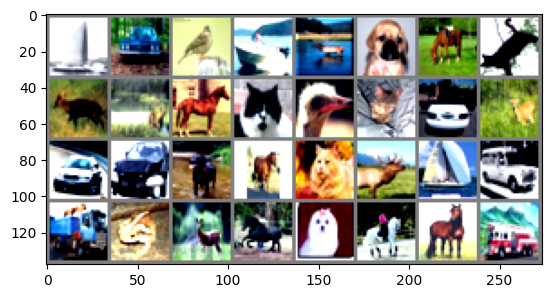

Labels: ship car bird ship deer dog horse cat deer deer horse cat bird cat car deer car car dog horse cat deer ship car truck frog deer horse dog horse horse truck


In [ ]:
# Fonction pour afficher des images
def imshow(img):
    img = img / 2 + 0.5     # Dénormalisation
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Obtenir quelques images d'entraînement
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Afficher les images
imshow(torchvision.utils.make_grid(images))
print('Labels:', ' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))


Weare now implementing and training a CNN with a the following layes in order to classify the Cifat-10 images.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class BasicModel(nn.Module):
    def __init__(self):
        super(BasicModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) # Convolutional layer (3x3 kernel)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) # Convolutional layer (3x3 kernel)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) # Convolutional layer (3x3 kernel)
        self.pool = nn.MaxPool2d(2, 2) # Max pooling layer (2x2 pool size)
        self.batch_norm1 = nn.BatchNorm2d(32) # Batch normalization for the first conv layer
        self.batch_norm2 = nn.BatchNorm2d(64) # Batch normalization for the second conv layer
        self.batch_norm3 = nn.BatchNorm2d(128) # Batch normalization for the third conv layer
        self.fc1 = nn.Linear(128 * 4 * 4, 512) # Fully connected layer (reducing number of neurons)
        self.fc2 = nn.Linear(512, 10) # Fully connected layer (10 classes for CIFAR-10)

    def forward(self, x):
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x)))) # Activation -> BatchNorm -> Pooling
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x)))) # Activation -> BatchNorm -> Pooling
        x = self.pool(F.relu(self.batch_norm3(self.conv3(x)))) # Activation -> BatchNorm -> Pooling
        x = torch.flatten(x, 1) # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x)) # Activation for the first FC layer
        x = self.fc2(x) # No activation, raw scores to be passed to the loss
        return x


# Initialiser le modèle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = BasicModel().to(device)

# Définir la fonction de perte et l'optimiseur
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)


# Entraîner le modèle
for epoch in range(5):  # Boucler sur les epochs
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:  # Imprimer toutes les 2000 mini-batchs
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


Finished Training


Let's see the accuracy of the model

In [ ]:
# Tester le modèle
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on test images: %d %%' % (100 * correct / total))

Accuracy on test images: 76 %


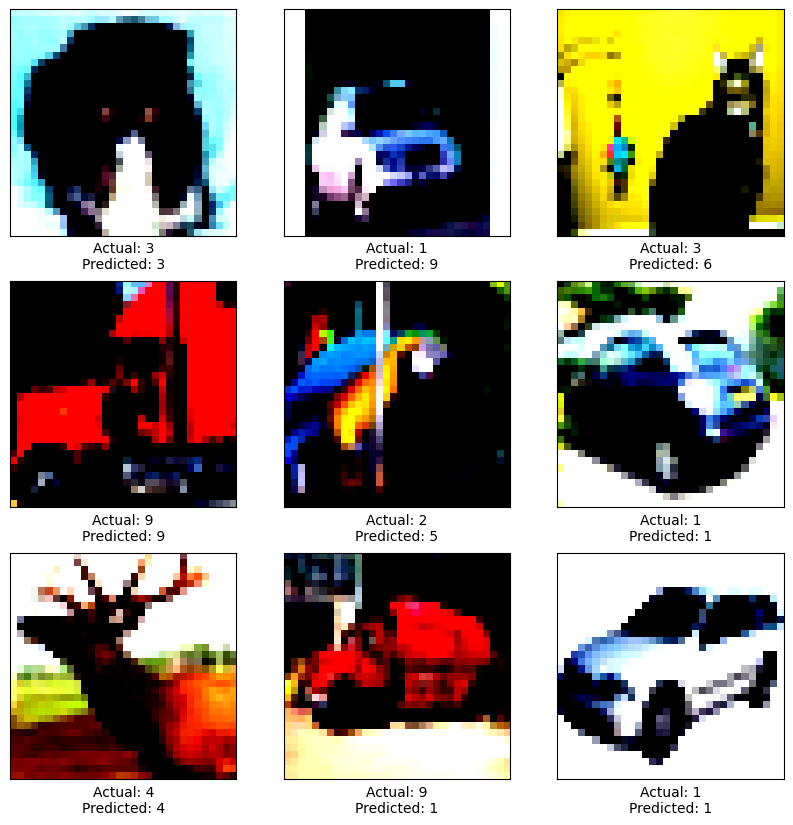

In [ ]:
import torch

import matplotlib.pyplot as plt

def show_predictions(images, labels, predictions):
    plt.figure(figsize=(10, 10))
    for i in range(len(images)):
        plt.subplot(3, 3, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].permute(1, 2, 0))  # Adjust for image format
        plt.xlabel(f"Actual: {labels[i]}\nPredicted: {predictions[i]}")
    plt.show()



# Make sure the model is in evaluation mode
net.eval()

# Get some test images; let's say we want to visualize 5 images
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Corrected this line
images, labels = images[:9], labels[:9]

# Move images to the same device as your model
images = images.to(device)

# Get predictions
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# Convert images and predictions to CPU for visualization
images = images.cpu()
predicted = predicted.cpu()

# Convert labels and predictions to a human-readable form if necessary
labels = labels.tolist()
predicted = predicted.tolist()

# Call your visualization function
show_predictions(images, labels, predicted)



The model has an accuracy of 40 % which is correct (better than a random classifier). Let's plot images with predictecd classes.

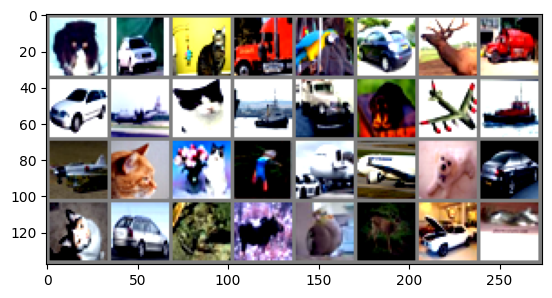

GroundTruth:  cat   car   cat   truck bird  car   deer  truck


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

Now that we have implemented a basic CNN we will try to fool it using 2 different technics.

Let's first implement FGSM.

In [ ]:
def fgsm_attack(model, loss, images, labels, epsilon):
    images = images.to(device)
    labels = labels.to(device)
    images.requires_grad = True

    outputs = model(images)

    model.zero_grad()
    cost = loss(outputs, labels)
    cost.backward()

    attack_images = images + epsilon * images.grad.sign()
    attack_images = torch.clamp(attack_images, 0, 1)

    return attack_images.cpu()



Let's plot fooled images.

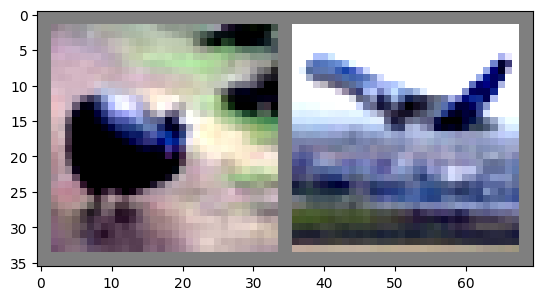

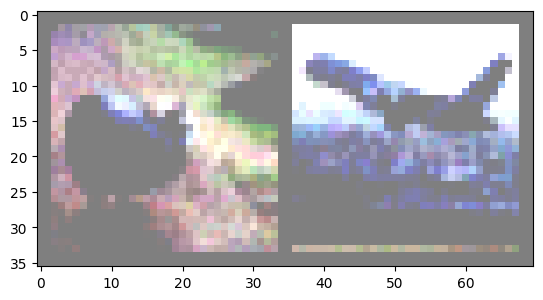

In [ ]:
model = net.to(device)
epsilon = 0.1
loss = nn.NLLLoss()

# Charger quelques images normales et leurs étiquettes depuis votre DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Appliquer l'attaque FGSM
images_attacked = fgsm_attack(model, loss, images, labels, epsilon)

# Afficher les images originales
imshow(torchvision.utils.make_grid(images[:2]))

# Afficher les images attaquées
imshow(torchvision.utils.make_grid(images_attacked[:2]))

Let's create a function to test the accuracy.

In [ ]:
def test_accuracy(net,loss,testloader,epsilon):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # calculate outputs by running images through the network
        attacked_image = fgsm_attack(net, loss, images, labels, epsilon)
        outputs = net(attacked_image.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()
    return 100* correct/total

#res=test_accuracy(net,loss,test_loader,epsilon=0.1)

#print(f'Accuracy of the network on the 10000 test images: {res} %')

Let's see the dependance of epsilon on the accuracy for FGSM attack.





In [ ]:
epsilon = []
for i in range(0,100,10):
  epsilon.append(i/1000)
res_list_fgsm=[]
for eps in epsilon:
    res_list_fgsm.append(test_accuracy(net,loss,test_loader,epsilon=eps))

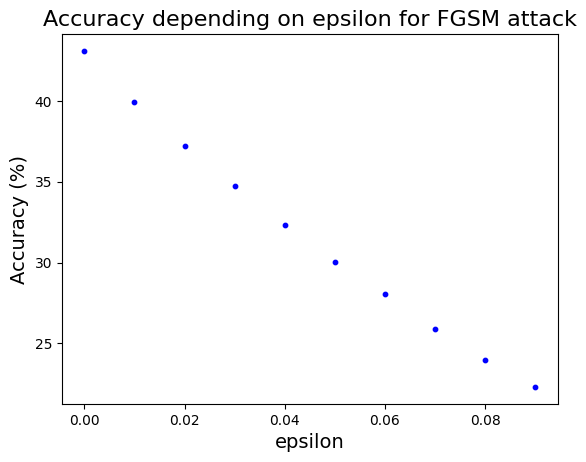

In [ ]:
plt.scatter(epsilon, res_list_fgsm, color='blue', s=10)

# Titres et labels des axes
plt.title("Accuracy depending on epsilon for FGSM attack", fontsize=16)
plt.xlabel('epsilon', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)

plt.show()

Projected Gradient Descent:

In [ ]:
def pgd_attack(model, loss, images, labels, eps=0.3, alpha=1/100, iters=40):
    images = images.to(device)
    labels = labels.to(device)
    ori_images = images.data

    for _ in range(iters):
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels)
        cost.backward()

        adv_images = images + alpha * images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()

    return images.cpu()





Let's see the difference between original image and attacked image.

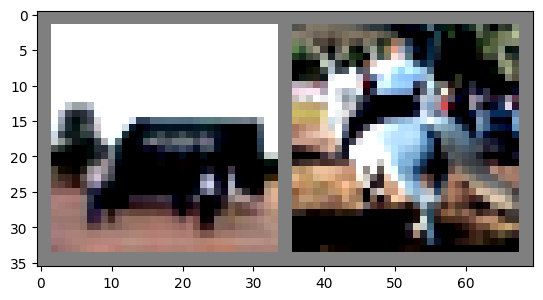

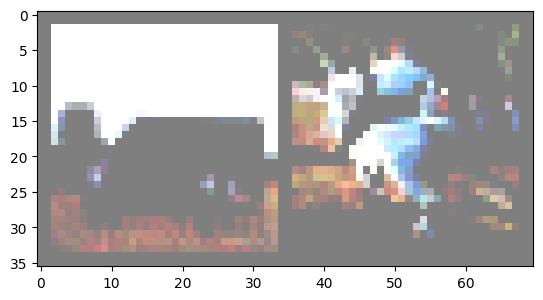

In [ ]:
model = net
epsilon = 0.1
loss = nn.CrossEntropyLoss()

# Réinitialiser l'itérateur
dataiter = iter(train_loader)

# Obtenir le prochain lot
images, labels = next(dataiter)

# Attaquer les images
images_attacked = pgd_attack(model, loss, images, labels, epsilon, iters=40)

# Afficher les images
imshow(torchvision.utils.make_grid(images[:2]))
imshow(torchvision.utils.make_grid(images_attacked[:2]))


In [ ]:
def test_accuracy_pgd(net,loss,testloader,epsilon,iter=20):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # calculate outputs by running images through the network
        attacked_image = pgd_attack(net, loss, images, labels, epsilon,iters=iter)
        outputs = net(attacked_image.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels).sum().item()
    return 100* correct/total

#res=test_accuracy_pgd(net,loss,test_loader,epsilon=0.01)

#print(f'Accuracy of the network on the 10000 test images: {res} %')

Let's see the dependance of epsilon on the accuracy for PGD attack.

In [ ]:
epsilon = []
for i in range(0,100,10):
  epsilon.append(i/1000)
res_list_pgd=[]
for eps in epsilon:
    res_list_pgd.append(test_accuracy_pgd(net,loss,test_loader,epsilon=eps))


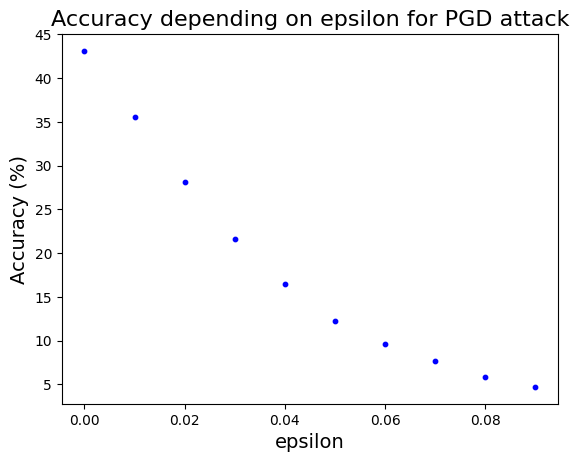

In [ ]:
plt.scatter(epsilon, res_list_pgd, color='blue', s=10)

# Titres et labels des axes
plt.title("Accuracy depending on epsilon for PGD attack", fontsize=16)
plt.xlabel('epsilon', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)

plt.show()

ADVERSARIAL TRAINING

In [ ]:
def train_model_adv(net, train_loader, pth_filename, num_epochs, adv="FGSM", epsilon=0.1):
    print("Starting training")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            if adv == "FGSM":
                inputs = fgsm_attack(net, criterion, inputs, labels, epsilon)
            else:
                inputs = pgd_attack(net, criterion, inputs, labels, epsilon, iters=20)

            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    torch.save(net.state_dict(), pth_filename)
    print('Model saved in {}'.format(pth_filename))

# Example usage
net2 = BasicModel()
net2.to(device)
train_model_adv(net2, train_loader, "adv_model.pth", 10, adv="FGSM", epsilon=0.1)


Starting training
[1,   500] loss: 0.506
[1,  1000] loss: 0.469
[2,   500] loss: 0.442
[2,  1000] loss: 0.429
[3,   500] loss: 0.401
[3,  1000] loss: 0.392
[4,   500] loss: 0.365
[4,  1000] loss: 0.364
[5,   500] loss: 0.340
[5,  1000] loss: 0.337
[6,   500] loss: 0.307
[6,  1000] loss: 0.317
[7,   500] loss: 0.286
[7,  1000] loss: 0.296
[8,   500] loss: 0.263
[8,  1000] loss: 0.275
[9,   500] loss: 0.240
[9,  1000] loss: 0.252
[10,   500] loss: 0.219
[10,  1000] loss: 0.233
Model saved in adv_model.pth


In [ ]:
net2=BasicModel()
net2.to(device)

BasicModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
train_model_adv(net2,train_loader,"adv_model",10,adv="FGSM",epsilon=0.1)
eps_list=[i/1000 for i in range(0,100,10)]
res_list_fgsm_adv_=[]
loss=nn.NLLLoss()
for eps in eps_list:
    res_list_fgsm_adv_.append(test_accuracy(net2,loss,test_loader,epsilon=eps))

Starting training
[1,   500] loss: 0.504
[1,  1000] loss: 0.472
[2,   500] loss: 0.443
[2,  1000] loss: 0.431
[3,   500] loss: 0.399
[3,  1000] loss: 0.394
[4,   500] loss: 0.361
[4,  1000] loss: 0.361
[5,   500] loss: 0.334
[5,  1000] loss: 0.336
[6,   500] loss: 0.308
[6,  1000] loss: 0.314
[7,   500] loss: 0.284
[7,  1000] loss: 0.291
[8,   500] loss: 0.265
[8,  1000] loss: 0.270
[9,   500] loss: 0.239
[9,  1000] loss: 0.251
[10,   500] loss: 0.215
[10,  1000] loss: 0.226
Model saved in adv_model


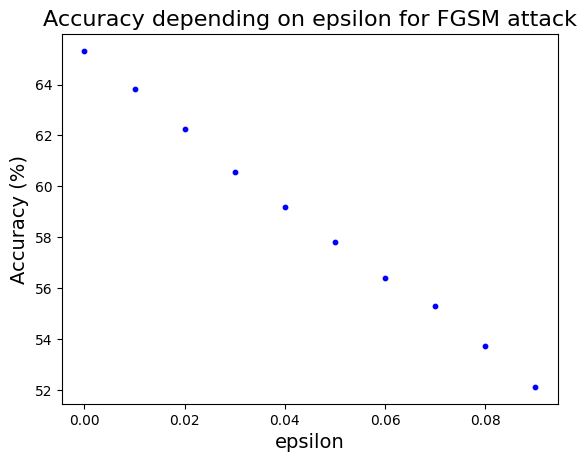

In [ ]:
plt.scatter(epsilon, res_list_fgsm_adv_, color='blue', s=10)

# Titres et labels des axes
plt.title("Accuracy depending on epsilon for FGSM attack", fontsize=16)
plt.xlabel('epsilon', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)

plt.show()

In [ ]:
net2=BasicModel()
net2.to(device)

BasicModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
train_model_adv(net2,train_loader,"adv_model",10,adv="pgd",epsilon=0.1)
eps_list=[i/1000 for i in range(0,100,10)]
res_list_pgd_adv_=[]
loss=nn.NLLLoss()
for eps in eps_list:
    res_list_pgd_adv_.append(test_accuracy(net2,loss,test_loader,epsilon=eps))

Starting training
[1,   500] loss: 0.532
[1,  1000] loss: 0.506
[2,   500] loss: 0.489
[2,  1000] loss: 0.481
[3,   500] loss: 0.469
[3,  1000] loss: 0.464
[4,   500] loss: 0.454
[4,  1000] loss: 0.450
[5,   500] loss: 0.442
[5,  1000] loss: 0.437
[6,   500] loss: 0.428
[6,  1000] loss: 0.431
[7,   500] loss: 0.418
[7,  1000] loss: 0.422
[8,   500] loss: 0.407
[8,  1000] loss: 0.414
[9,   500] loss: 0.403
[9,  1000] loss: 0.405
[10,   500] loss: 0.394
[10,  1000] loss: 0.397
Model saved in adv_model


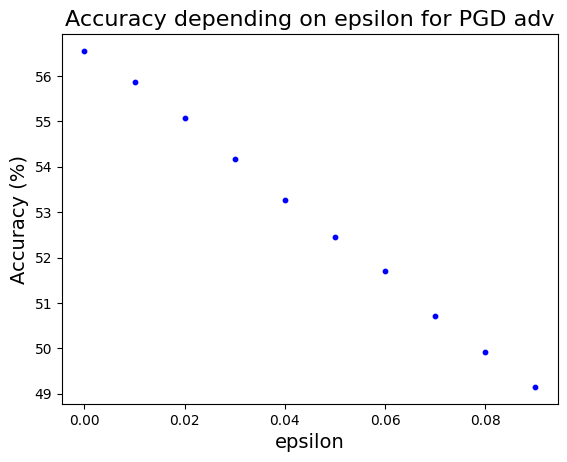

In [ ]:
plt.scatter(epsilon, res_list_pgd_adv_, color='blue', s=10)

# Titres et labels des axes
plt.title("Accuracy depending on epsilon for PGD adv", fontsize=16)
plt.xlabel('epsilon', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)

plt.show()

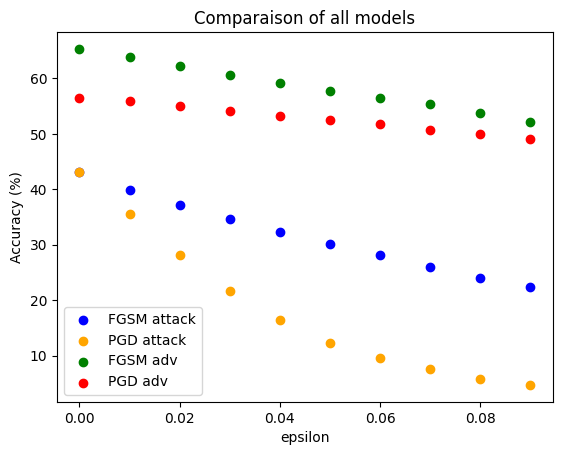

In [ ]:
fig, ax = plt.subplots()

# Tracer les nuages de points avec des couleurs différentes
ax.scatter(epsilon, res_list_fgsm, label='FGSM attack', color='blue')
ax.scatter(epsilon, res_list_pgd, label='PGD attack', color='orange')
ax.scatter(epsilon, res_list_fgsm_adv_, label='FGSM adv', color='green')
ax.scatter(epsilon, res_list_pgd_adv_, label='PGD adv', color='red')

# Ajouter des étiquettes et une légende
ax.set_xlabel('epsilon')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Comparaison of all models')
ax.legend()

# Afficher le graphique
plt.show()

In [ ]:
res_list_fgsm

[43.1, 39.92, 37.21, 34.72, 32.3, 30.05, 28.07, 25.9, 23.98, 22.3]

In [ ]:
res_list_pgd

[43.1, 35.57, 28.08, 21.65, 16.49, 12.24, 9.65, 7.65, 5.82, 4.71]

In [ ]:
res_list_fgsm_adv_

[65.32, 63.84, 62.25, 60.56, 59.19, 57.81, 56.4, 55.31, 53.72, 52.13]

In [ ]:
res_list_pgd_adv_

[56.55, 55.86, 55.08, 54.16, 53.27, 52.45, 51.71, 50.72, 49.93, 49.15]